<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/master/pix2pix_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 63kB/s 
     |████████████████████████████████| 4.3MB 27.8MB/s 
     |████████████████████████████████| 501kB 40.9MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import Model, Sequential, optimizers, layers
from skimage.io import imshow

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 2s 0us/step


In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  
  w = tf.shape(image)[1]
  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

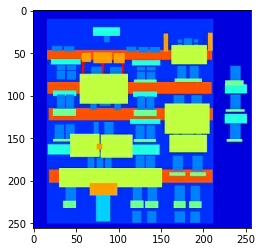

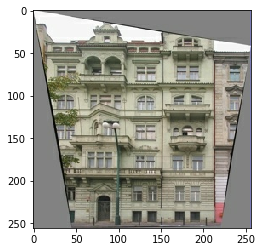

In [0]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [0]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

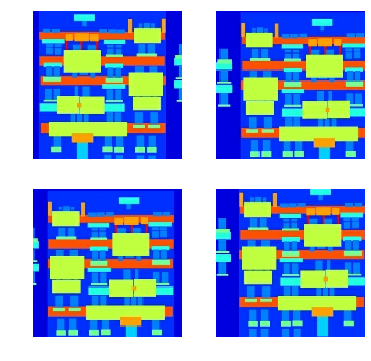

In [0]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
# this method shuffle data by default.
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE) # cache in memory
train_dataset = train_dataset.batch(1) # ?

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [0]:
def downsample(filters, kernel_size, apply_batchnorm=True):
  # Conv -> BatchNormalization(opt.) -> LeakyReLU
  initializer = tf.random_normal_initializer(0., 0.02)

  block = Sequential()
  block.add(layers.Conv2D(filters, kernel_size, strides=(2,2), padding='same',
                                   kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    block.add(layers.BatchNormalization())

  block.add(layers.LeakyReLU())

  return block 

In [0]:
# test dimension: [256,256,3] -> [1,256,256,3] -> [1,128,128,3]
down_result = downsample(3,4)(tf.expand_dims(inp, 0))
down_result.shape

TensorShape([1, 128, 128, 3])

In [0]:
def upsample(filters, kernel_size, apply_dropout=False):
  # deConv -> BN -> Droupout(opt.) -> LeakyReLU
  initializer = tf.random_normal_initializer(0., 0.02)

  block = Sequential()
  block.add(layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                                   kernel_initializer=initializer, use_bias=False))
  
  block.add(layers.BatchNormalization())

  if apply_dropout:
    block.add(layers.Dropout(0.5))

  block.add(layers.LeakyReLU())

  return block

In [0]:
# test dimension: [1,128,128,3] -> [1,256,256,3]
up_result = upsample(3,4)(down_result)
up_result.shape

TensorShape([1, 256, 256, 3])

In [0]:
OUTPUT_CHANNELS = 3
def Generator():
  # U Net
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # bs, 128, 128, 64
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4) # [batch_size, 1, 1, 512], no highway(shortcut)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4)  # [batch_size, 128, 128, 64]
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last_layer = layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                      (4,4),
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') # (batch_size, 256, 256, 3)

  # build architecture here.
  x = inputs = layers.Input(shape=[None, None, 3]) # for diff. size of img??

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1]) # small_dim -> big_dim ; exclude the lowerest point
  
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])
  # bs, 128, 128, (64+64)

  x = last_layer(x) # bs, 256, 256, 3

  return Model(inputs=inputs, outputs=x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


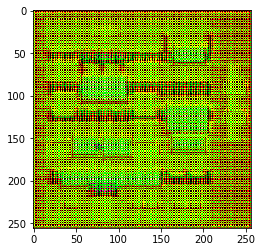

In [0]:
generator = Generator()

gen_output = generator(inp[tf.newaxis, ...], training=False)
# result before training.
plt.imshow(gen_output[0, ...])

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  input_image = layers.Input(shape=[None, None, 3])
  target_image = layers.Input(shape=[None, None, 3])

  # (batch_size, 256, 256, 3x2)
  x = layers.concatenate([input_image, target_image]) 

  d1 = downsample(64, 4, apply_batchnorm=False)(x)
  d2 = downsample(128, 4)(d1)
  d3 = downsample(256, 4)(d2) # (batch_size, 32, 32, 256)

  zero_pad1 = layers.ZeroPadding2D()(d3) # (batch_size, 34, 34, 256)
  conv = layers.Conv2D(512, (4,4), strides=(1,1),
                       kernel_initializer=initializer,
                       use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)

  bn = layers.BatchNormalization()(conv)
  leaky_relu = layers.LeakyReLU()(bn)
  zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
  
  # bs, 30, 30, 1
  output_layer = layers.Conv2D(1, (4,4), strides=(1,1),
                               kernel_initializer=initializer)(zero_pad2)

  return Model(inputs=[input_image, target_image], outputs=output_layer)                                           

In [0]:
discriminator = Discriminator()
# maybe visualize D's result here.

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def generator_loss(disc_gen_output, gen_output, target):
  gen_loss = loss_object(tf.ones_like(disc_gen_output), disc_gen_output)

  L1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  return gen_loss + LAMBDA * L1_loss

In [0]:
def discriminator_loss(disc_real_output, disc_gen_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_gen_output)
  gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)

  return real_loss + gen_loss

In [0]:
generator_optimizer = optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = 'drive/My Drive/Colab Notebooks/mount/checkpoint/pixel2pixel'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # Train
    for input_image, target in train_ds:
      train_step(input_image, target)

    clear_output(wait=True)
    # Test on the same image so that the progress of the model can be 
    # easily seen.
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

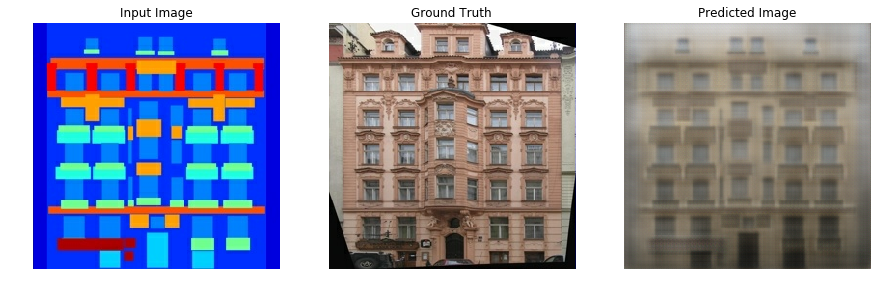

Time taken for epoch 10 is 904.8757283687592 sec



In [0]:
EPOCHS = 10
fit(train_dataset, EPOCHS, test_dataset)

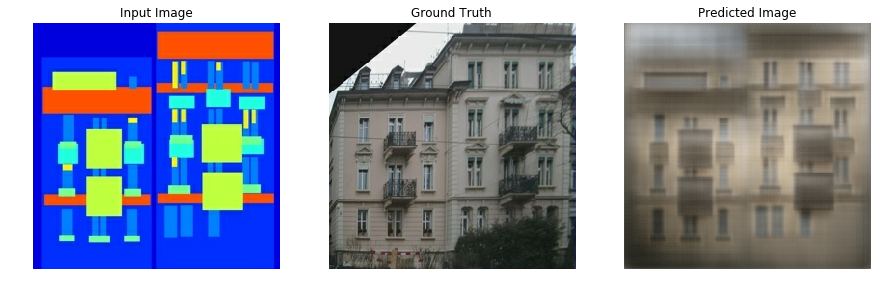

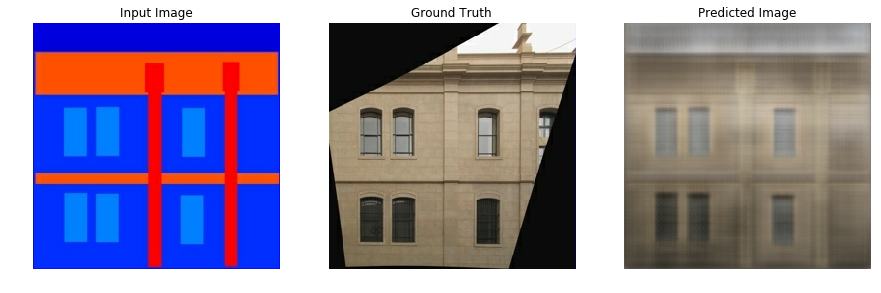

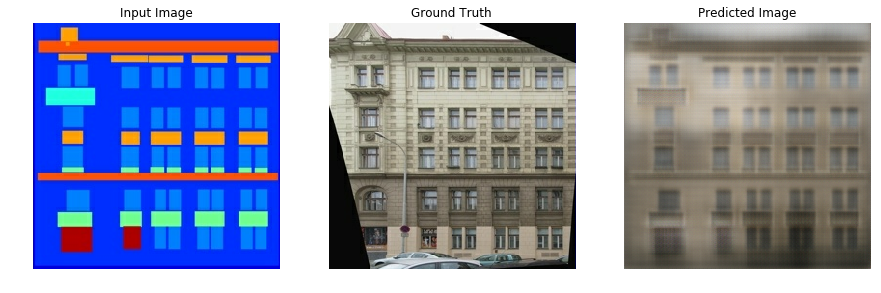

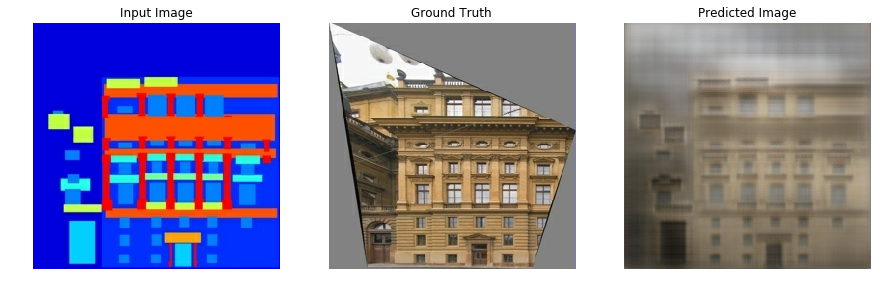

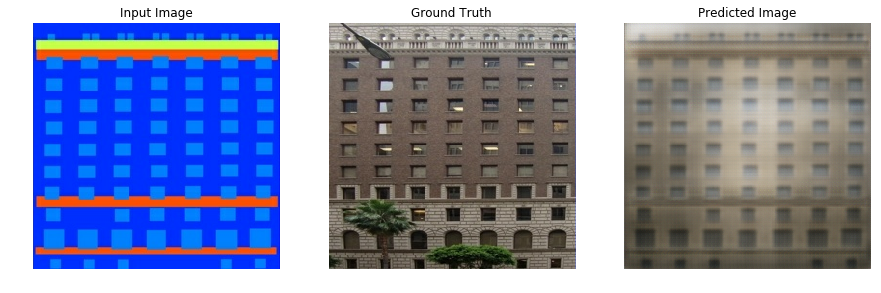

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)